# Data 102 Final Project

### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install statsmodels
import statsmodels.api as sm
import seaborn as sns
import itertools
!pip install ipywidgets
from ipywidgets import interact, interactive
import hashlib

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline
pd.options.mode.chained_assignment = None

!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
from datetime import datetime
from shapely.geometry import Point
from shapely.ops import nearest_points
!pip install geopy
from geopy.distance import geodesic
pd.options.mode.chained_assignment = None  # default='warn'

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Load the Data

In [ ]:
# Mobility Data
us_2020_mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')
us_2020_mobility['date'] = pd.to_datetime(us_2020_mobility.date)
us_2021_mobility = pd.read_csv('2021_US_Region_Mobility_Report.csv')
us_2021_mobility['date'] = pd.to_datetime(us_2021_mobility.date)
us_2022_mobility = pd.read_csv('2022_US_Region_Mobility_Report.csv')
us_2022_mobility['date'] = pd.to_datetime(us_2022_mobility.date)

# Covid Data
covid = pd.read_csv('covid19cases_test.csv')
vax = pd.read_csv('covid19vaccinesbycounty.csv')
policy = pd.read_csv('OxCGRT_US_latest.csv')

# More data for Question 2

In [ ]:
# Alameda County 2021 Mobility Data
alameda_2020_mobility = us_2020_mobility[(us_2020_mobility['sub_region_1']=='California')&(us_2020_mobility['sub_region_2']=='Alameda County')]
alameda_2020_mobility.drop(alameda_2020_mobility.iloc[:,:8],axis=1,inplace=True)
alameda_2020_mobility['date']=pd.to_datetime(alameda_2020_mobility.date)

# Alameda County 2021 Mobility Data
alameda_2021_mobility = us_2021_mobility[(us_2021_mobility['sub_region_1']=='California')&(us_2021_mobility['sub_region_2']=='Alameda County')]
alameda_2021_mobility.drop(alameda_2021_mobility.iloc[:,:8],axis=1,inplace=True)
alameda_2021_mobility['date']=pd.to_datetime(alameda_2021_mobility.date)

# Alameda County Covid Cases Data
alameda_covid = covid[covid['area']=='Alameda']
alameda_covid = alameda_covid[['date','cases','deaths']]
alameda_covid['date']=pd.to_datetime(alameda_covid.date)

# Alameda County Covid Vaccination Data
alameda_vax = vax[vax['county']=='Alameda']
alameda_vax = alameda_vax[['administered_date','total_doses']]
alameda_vax.rename(columns={'administered_date':'date'},inplace=True)
alameda_vax['date']=pd.to_datetime(alameda_vax.date)

# California Covid Policy
ca_policy = policy[policy['RegionName']=='California']
ca_policy['date'] = pd.to_datetime(ca_policy['Date'],format='%Y%m%d')
ca_policy = ca_policy[['date','C1_School closing','C2_Workplace closing','C3_Cancel public events','C4_Restrictions on gatherings','C5_Close public transport','C6_Stay at home requirements']]

# Merge the above datasets together
covid_vax = alameda_covid.merge(alameda_vax,how='inner',on='date')
combined_mobility = covid_vax.merge(alameda_2021_mobility,how='inner',on='date')
combined_mobility['date'] = pd.to_datetime(combined_mobility['date'],infer_datetime_format=True)
q1_data = combined_mobility.merge(ca_policy,how='inner',on='date')

## Data Overview

### Google: COVID-19 Community Mobility Reports

This dataset shows how our community is moving around differently due to COVID-19. Specifically, this reports show hos visits and length of stay at different places, including retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential, change compared to pre-covid baseline.

Dataset Source: *Google LLC "Google COVID-19 Community Mobility Reports". https://www.google.com/covid19/mobility/*

In [ ]:
us_2021_mobility.sample(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
507450,US,United States,Nebraska,Colfax County,NaN,NaN,31037.0,ChIJt3O5GjH8kIcRzHjDMGOwDFw,2021-08-12,NaN,NaN,NaN,NaN,-15.0,NaN
347349,US,United States,Louisiana,Lincoln Parish,NaN,NaN,22061.0,ChIJzUs1fb_EMYYRCYKLnWkcJ6A,2021-05-27,3.0,3.0,NaN,NaN,-34.0,3.0
775398,US,United States,Texas,Cherokee County,NaN,NaN,48073.0,ChIJrWw1l9sZSIYRE8vLZzPzXWA,2021-05-05,20.0,8.0,NaN,NaN,-13.0,1.0
299451,US,United States,Kansas,Russell County,NaN,NaN,20167.0,ChIJy-U6m2qzo4cRux1S6uff0VA,2021-09-20,NaN,NaN,NaN,NaN,-6.0,NaN
605771,US,United States,North Dakota,NaN,NaN,US-ND,NaN,ChIJY-nYVxKD11IRyc9egzmahA0,2021-11-21,-2.0,0.0,-6.0,-3.0,-7.0,1.0


### COVID-19 Time-Series Metrics by County and State

This data shows covid cases, deaths, and tests in california counties on specific dates. All metrics include people in state and federal prisons, US Immigration and Customs Enforcement facilities, US Marshal detention facilities, and Department of State Hospitals facilities. Members of California's tribal communities are also included.

*Data is from the California COVID-19 State Dashboard at https://covid19.ca.gov/state-dashboard/*

In [ ]:
covid.head(5)

,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
0,2020-02-01,Alameda,County,1685886.0,3.0,3.0,0.0,0.0,4.0,4,0.0,0,0.0,0.0,0.0,0.0,NaN
1,2020-02-02,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
2,2020-02-03,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
3,2020-02-04,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
4,2020-02-05,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,6,0.0,0,0.0,0.0,0.0,0.0,NaN


### COVID-19 Vaccine Progress Dashboard Data

This dataset summarizes vaccination data at the county level by county of residence. 

*This data is from the same source as the Vaccine Progress Dashboard at https://covid19.ca.gov/vaccination-progress-data/*

In [ ]:
vax.head(5)

,county,administered_date,total_doses,cumulative_total_doses,pfizer_doses,cumulative_pfizer_doses,moderna_doses,cumulative_moderna_doses,jj_doses,cumulative_jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,california_flag,booster_recip_count,cumulative_booster_recip_count
0,Alameda,2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0
1,Alameda,2020-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0
2,Alameda,2020-07-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0
3,Alameda,2020-07-29,0,1,0,0,0,1,0,0,0,1,0,0,0,1,NaN,0,0
4,Alameda,2020-07-30,0,1,0,0,0,1,0,0,0,1,0,0,0,1,NaN,0,0


### USA State Level COVID-19 Policy Responses

This dataset contains systematic information on several different common policy responses governments have taken during the pandemic. These policies are recorded on a scale to reflect the extent of government action and the scores are aggregated into a suite of policy indices. The dataset contains 21 indicators and a miscellaneous notes field organised into five groups:
- C - containment and closure policies
- E - economic policies
- H - health system policies
- V - vaccination policies
- M - miscellaneous policies

In our project, we will focus primarily on category C. 

Dataset Source: *Laura Hallas, Ariq Hatibie, Saptarshi Majumdar, Monika Pyarali, Rachelle Koch, Andrew Wood and Thomas Hale (2020). [Variation in US states’ responses to COVID-19_3.0] (https://www.bsg.ox.ac.uk/research/publications/variation-us-states-responses-covid-19). Blavatnik School of Government.*

In [ ]:
policy.sample(5)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C1_Notes,C2_Workplace closing,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
18362,United States,USA,Maryland,US_MD,STATE_WIDE,20210729,2.0,0.0,NaN,0.0,...,16.67,16.67,21.43,21.43,36.20,36.20,34.23,34.23,50.0,50.0
14533,United States,USA,Kansas,US_KS,STATE_WIDE,20200514,3.0,1.0,NaN,2.0,...,69.44,69.44,75.00,75.00,58.85,58.85,60.12,60.12,50.0,50.0
17992,United States,USA,Maryland,US_MD,STATE_WIDE,20200724,3.0,0.0,NaN,1.0,...,56.94,56.94,64.29,64.29,58.07,58.07,59.23,59.23,50.0,50.0
25290,United States,USA,North Dakota,US_ND,STATE_WIDE,20211228,1.0,0.0,NaN,0.0,...,26.85,26.85,36.90,36.90,46.61,46.61,46.13,46.13,50.0,50.0
34816,United States,USA,South Carolina,US_SC,STATE_WIDE,20200330,3.0,1.0,NaN,1.0,...,62.04,62.04,64.29,64.29,52.60,52.60,52.98,52.98,50.0,50.0


### NO2 Daily Concentration Level in 2020
This dataset records the daily measurement of NO2 pollutant concentration in each county in California. There are six meansures per day in each location. Each row represents the record of each measurement. Since we use date as a key to combine this data with the mobility data and there are six data points for each day, we may need to find the average concentration for each day. 

*This dataset is obtained from the United States Environmental Protection Agency website: https://www.epa.gov/outdoor-air-quality-data/download-daily-data*


In [ ]:
NO2_2020_cal = pd.read_csv("NO2_2020_CAL.csv")
NO2_2020_cal['Date'] = pd.to_datetime(NO2_2020_cal.Date)
NO2_2020_cal.head()

,Date,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,2020-01-01,AQS,60010007,1,18.5,ppb,17,Livermore,23,96.0,42602,Nitrogen dioxide (NO2),41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
1,2020-01-02,AQS,60010007,1,22.7,ppb,21,Livermore,23,96.0,42602,Nitrogen dioxide (NO2),41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
2,2020-01-03,AQS,60010007,1,23.6,ppb,22,Livermore,23,96.0,42602,Nitrogen dioxide (NO2),41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
3,2020-01-04,AQS,60010007,1,21.2,ppb,20,Livermore,23,96.0,42602,Nitrogen dioxide (NO2),41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
4,2020-01-05,AQS,60010007,1,23.0,ppb,22,Livermore,23,96.0,42602,Nitrogen dioxide (NO2),41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217


## EDA

### 2020 Alameda County Community Mobility Change from baseline

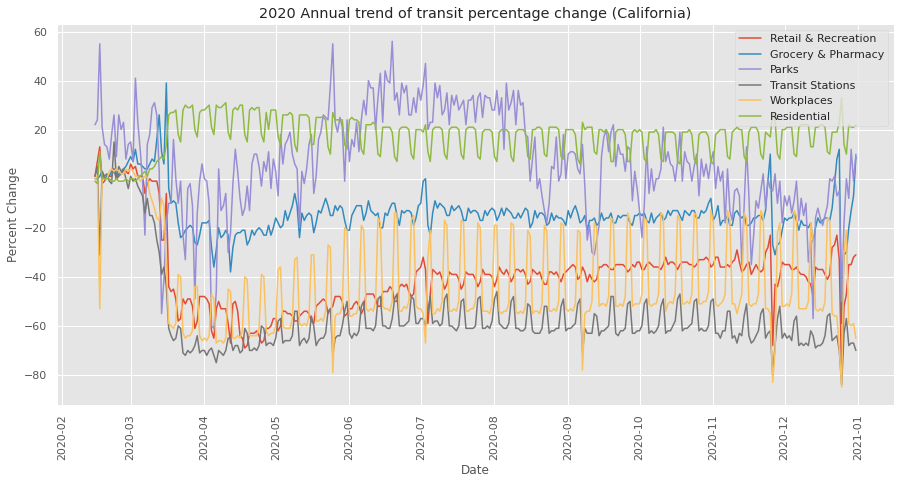

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["retail_and_recreation_percent_change_from_baseline"],label='Retail & Recreation');
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["grocery_and_pharmacy_percent_change_from_baseline"],label='Grocery & Pharmacy');
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["parks_percent_change_from_baseline"],label='Parks');
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["transit_stations_percent_change_from_baseline"],label='Transit Stations');
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["workplaces_percent_change_from_baseline"],label='Workplaces');
plt.plot(alameda_2020_mobility["date"],alameda_2020_mobility["residential_percent_change_from_baseline"],label='Residential');
plt.legend()
plt.xlabel("Date")
plt.ylabel("Percent Change")
plt.xticks(rotation=90); 
plt.title("2020 Annual trend of transit percentage change (California)");

### 2020 Alameda County Community Mobility Change from baseline

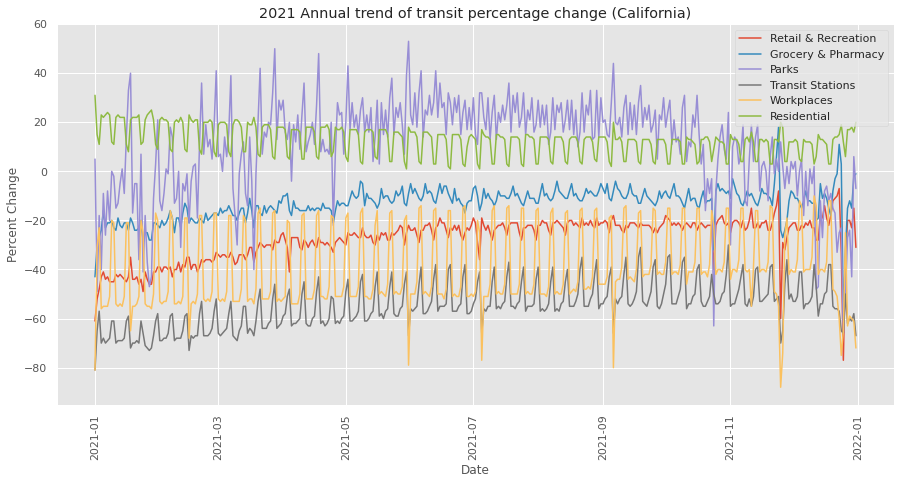

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["retail_and_recreation_percent_change_from_baseline"],label='Retail & Recreation');
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["grocery_and_pharmacy_percent_change_from_baseline"],label='Grocery & Pharmacy');
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["parks_percent_change_from_baseline"],label='Parks');
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["transit_stations_percent_change_from_baseline"],label='Transit Stations');
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["workplaces_percent_change_from_baseline"],label='Workplaces');
plt.plot(alameda_2021_mobility["date"],alameda_2021_mobility["residential_percent_change_from_baseline"],label='Residential');
plt.legend()
plt.xlabel("Date")
plt.ylabel("Percent Change")
plt.xticks(rotation=90); 
plt.title("2021 Annual trend of transit percentage change (California)");

### Alameda County Covid Cases

The figure below shows the trend of covid cases in Alameda County since the pandemic started in 2020. There are two major peaks of pandemic outbreak, first in Jan 2021, and the second with much higher covid cases in Jan 2022.

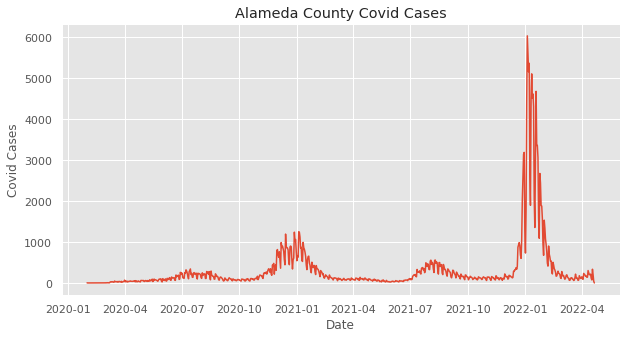

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(alameda_covid['date'],alameda_covid['cases'])
plt.xlabel("Date")
plt.ylabel("Covid Cases")
plt.title("Alameda County Covid Cases");

### Alameda County Covid Vacciniation

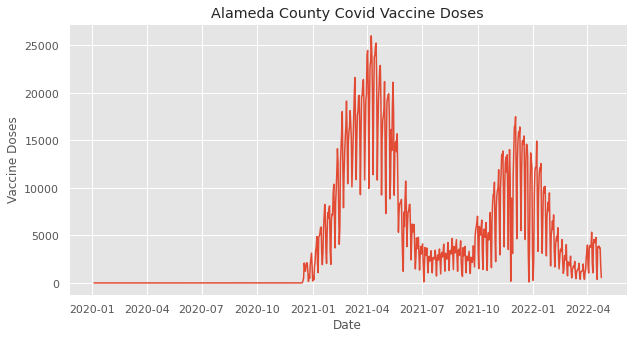

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(alameda_vax['date'],alameda_vax['total_doses'])
plt.xlabel("Date")
plt.ylabel("Vaccine Doses")
plt.title("Alameda County Covid Vaccine Doses");

### Change in residential mobility under Stay at home requirements

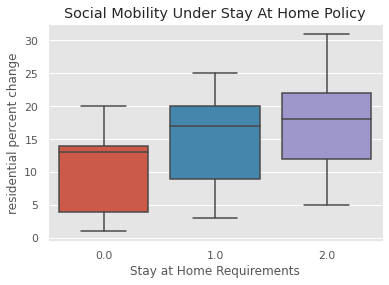

In [ ]:
sns.boxplot(x='C6_Stay at home requirements',y='residential_percent_change_from_baseline',data=q1_data)
plt.xlabel('Stay at Home Requirements')
plt.ylabel('residential percent change')
plt.title("Social Mobility Under Stay At Home Policy");

### NO2 Pollutant Measurement Distribution in the California in 2020

Text(171.77524635053223, 0.5, 'Latitude')

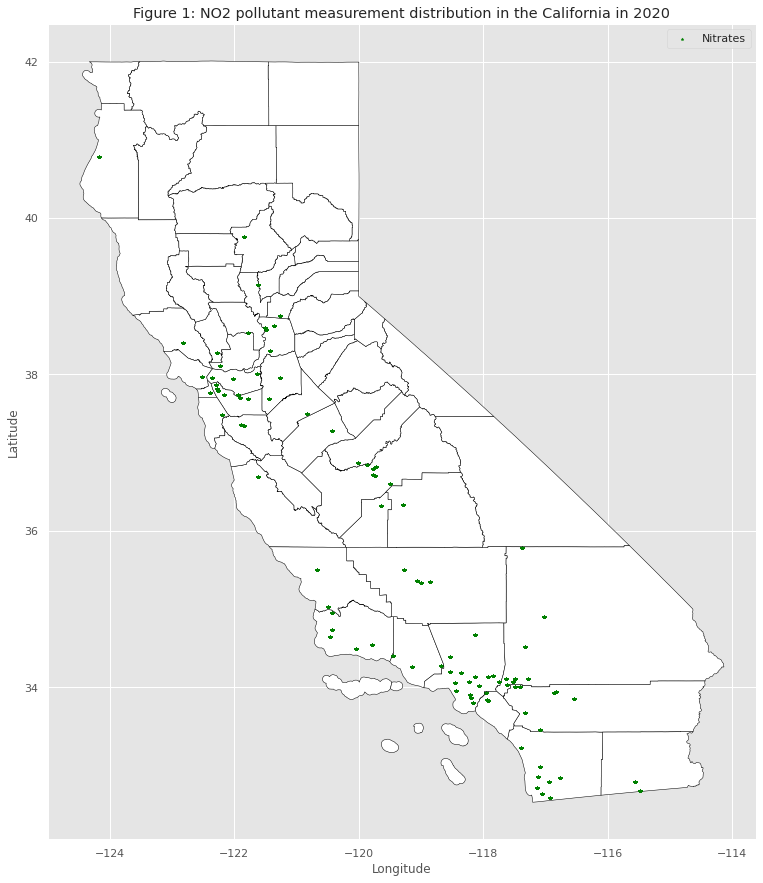

In [ ]:
NO2_2020_cal = gpd.GeoDataFrame(NO2_2020_cal)

NO2_2020_cal = gpd.GeoDataFrame(NO2_2020_cal, geometry = gpd.points_from_xy(NO2_2020_cal['SITE_LONGITUDE'], NO2_2020_cal['SITE_LATITUDE']))

counties = gpd.read_file('County_Boundry/CA_Counties_TIGER2016.shp')
counties = counties.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
NO2_2020_cal.plot(ax= ax,marker='*', color='green', markersize=8, zorder=3, label = 'Nitrates')
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
leg = ax.legend();
plt.title('Figure 1: NO2 pollutant measurement distribution in the California in 2020');
plt.xlabel("Longitude")
plt.ylabel("Latitude")

### NO2 concentration level across California in 2020

Text(107.5, 0.5, 'Latitude')

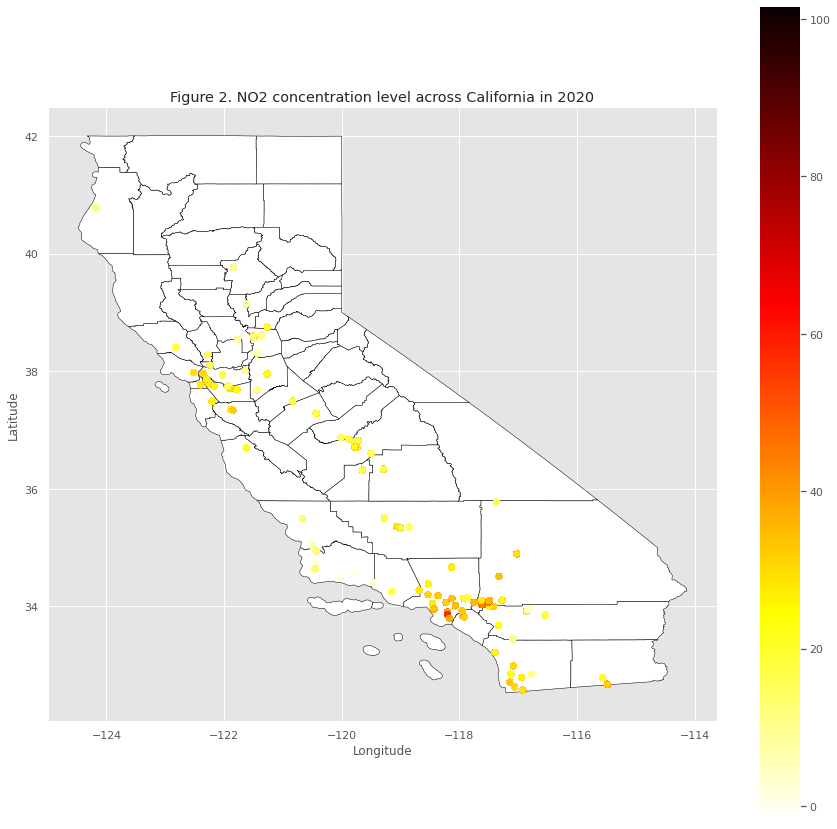

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title("Figure 2. NO2 concentration level across California in 2020")
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
NO2_2020_cal.plot(ax = ax, column = 'Daily Max 1-hour NO2 Concentration',cmap='hot_r',legend=True);
plt.xlabel("Longitude")
plt.ylabel("Latitude")

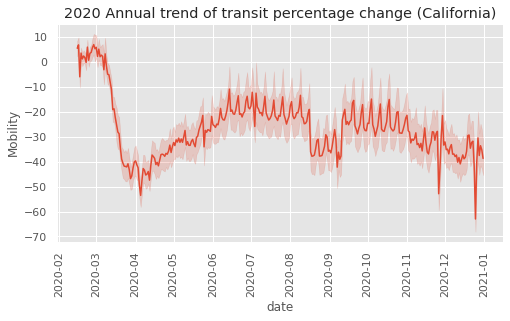

In [ ]:
cal_data_2020 = us_2020_mobility[us_2020_mobility["sub_region_1"] == "California"].loc[:, ("sub_region_2", "date", "transit_stations_percent_change_from_baseline")]
fig = plt.figure(figsize=(8, 4))
sns.lineplot(x = cal_data_2020["date"], y = cal_data_2020["transit_stations_percent_change_from_baseline"]); # 2020 mobility plot
plt.xticks(rotation=90); 
plt.title("2020 Annual trend of transit percentage change (California)");
plt.ylabel("Mobility");

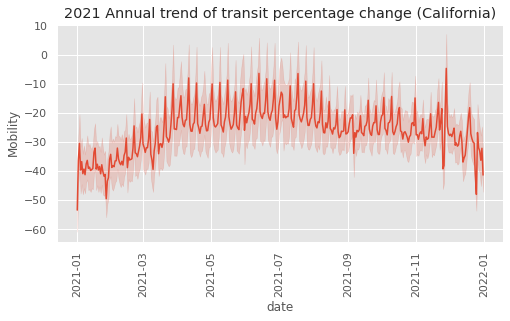

In [ ]:
cal_data_2021 = us_2021_mobility[us_2021_mobility["sub_region_1"] == "California"].loc[:, ("sub_region_2", "date", "transit_stations_percent_change_from_baseline")]
fig = plt.figure(figsize=(8, 4))
sns.lineplot(x = cal_data_2021["date"], y = cal_data_2021["transit_stations_percent_change_from_baseline"]); # 2021 mobility plot
plt.xticks(rotation=90);
plt.title("2021 Annual trend of transit percentage change (California)");
plt.ylabel("Mobility");

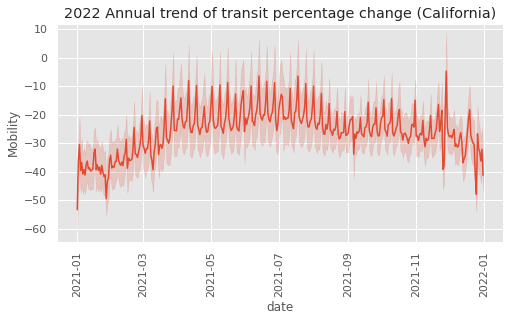

In [ ]:
cal_data_2022 = us_2021_mobility[us_2021_mobility["sub_region_1"] == "California"].loc[:, ("sub_region_2", "date", "transit_stations_percent_change_from_baseline")]
fig = plt.figure(figsize=(8, 4))
sns.lineplot(x = cal_data_2022["date"], y = cal_data_2022["transit_stations_percent_change_from_baseline"]) # 2022 mobility plot
plt.xticks(rotation=90);
plt.title("2022 Annual trend of transit percentage change (California)");
plt.ylabel("Mobility");

Next, we only selected the data that contain the six counties we need and also only kept the date, transit mobility percentage change and daily max concentration column and dropped the other columns.

In [ ]:
alameda_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "Alameda County"]
la_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "Los Angeles County"]
sd_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "San Diego County"]
fresno_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "Fresno County"]
orange_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "Orange County"]
sacramento_2020 = cal_data_2020[cal_data_2020["sub_region_2"] == "Sacramento County"]

In [ ]:
NO2_2020_alameda = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "Alameda"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_alameda = NO2_2020_alameda.groupby("Date").agg(np.mean).reset_index()
NO2_2020_la = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "Los Angeles"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_la = NO2_2020_la.groupby("Date").agg(np.mean).reset_index()
NO2_2020_sd = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "San Diego"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_sd = NO2_2020_sd.groupby("Date").agg(np.mean).reset_index()
NO2_2020_fresno = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "Fresno"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_fresno = NO2_2020_fresno.groupby("Date").agg(np.mean).reset_index()
NO2_2020_orange = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "Orange"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_orange = NO2_2020_orange.groupby("Date").agg(np.mean).reset_index()
NO2_2020_sacramento = NO2_2020_cal[NO2_2020_cal["COUNTY"] == "Sacramento"].loc[:, ["Date", "Daily Max 1-hour NO2 Concentration", "COUNTY"]]
NO2_2020_sacramento = NO2_2020_sacramento.groupby("Date").agg(np.mean).reset_index()


### Merge Mobility and NO2 Dataset for Each County

We merged the mobility and NO2 concentration data together by using date as a key.

In [ ]:
alameda_merge_2020 = alameda_2020.merge(NO2_2020_alameda, how = "inner", left_on = "date", right_on = "Date")
alameda_merge_2020.head()

,sub_region_2,date,transit_stations_percent_change_from_baseline,Date,Daily Max 1-hour NO2 Concentration
0,Alameda County,2020-02-15,1.0,2020-02-15,24.350000
1,Alameda County,2020-02-16,5.0,2020-02-16,20.916667
2,Alameda County,2020-02-17,-31.0,2020-02-17,27.750000
3,Alameda County,2020-02-18,3.0,2020-02-18,34.150000
4,Alameda County,2020-02-19,1.0,2020-02-19,31.366667


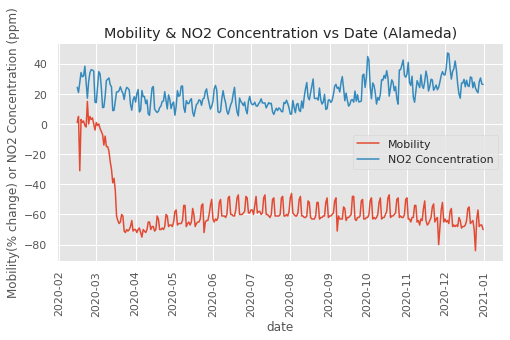

In [ ]:
fig = plt.figure(figsize=(8, 4))
sns.lineplot(x = alameda_merge_2020["date"], y = alameda_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = alameda_merge_2020["date"], y = alameda_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration"); 
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (Alameda)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

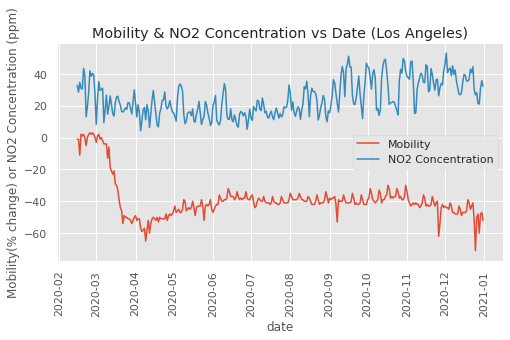

In [ ]:
fig = plt.figure(figsize=(8, 4))
la_merge_2020 = la_2020.merge(NO2_2020_la, how = "inner", left_on = "date", right_on = "Date")
sns.lineplot(x = la_merge_2020["date"], y = la_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = la_merge_2020["date"], y = la_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration");
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (Los Angeles)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

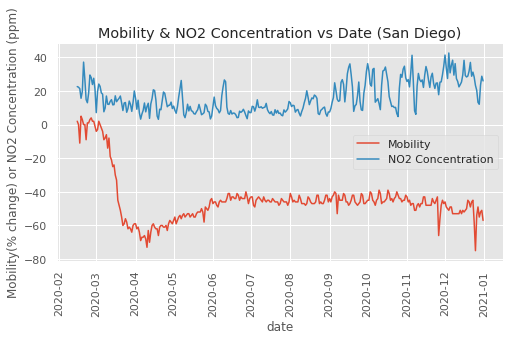

In [ ]:
fig = plt.figure(figsize=(8, 4))
sd_merge_2020 = sd_2020.merge(NO2_2020_sd, how = "inner", left_on = "date", right_on = "Date")
sns.lineplot(x = sd_merge_2020["date"], y = sd_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = sd_merge_2020["date"], y = sd_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration");
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (San Diego)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

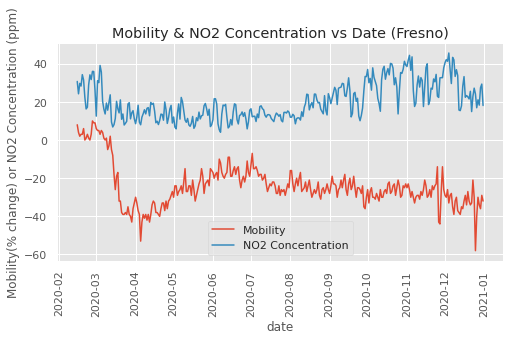

In [ ]:
fig = plt.figure(figsize=(8, 4))
fresno_merge_2020 = fresno_2020.merge(NO2_2020_fresno, how = "inner", left_on = "date", right_on = "Date")
sns.lineplot(x = fresno_merge_2020["date"], y = fresno_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = fresno_merge_2020["date"], y = fresno_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration");
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (Fresno)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

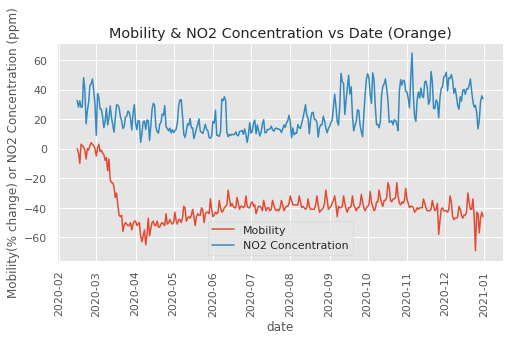

In [ ]:
fig = plt.figure(figsize=(8, 4))
orange_merge_2020 = orange_2020.merge(NO2_2020_orange, how = "inner", left_on = "date", right_on = "Date")
sns.lineplot(x = orange_merge_2020["date"], y = orange_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = orange_merge_2020["date"], y = orange_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration");
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (Orange)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

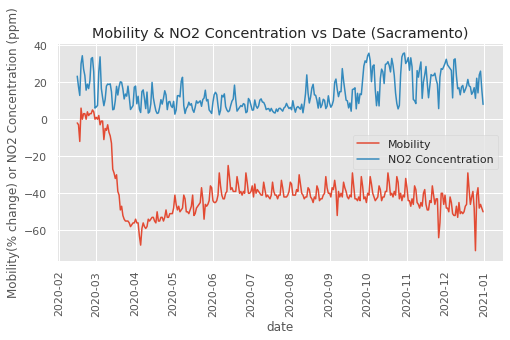

In [ ]:
fig = plt.figure(figsize=(8, 4))
sacramento_merge_2020 = sacramento_2020.merge(NO2_2020_sacramento, how = "inner", left_on = "date", right_on = "Date")
sns.lineplot(x = sacramento_merge_2020["date"], y = sacramento_merge_2020["transit_stations_percent_change_from_baseline"], label = "Mobility"); 
sns.lineplot(x = sacramento_merge_2020["date"], y = sacramento_merge_2020["Daily Max 1-hour NO2 Concentration"], label = "NO2 Concentration");
plt.xticks(rotation=90);
plt.title("Mobility & NO2 Concentration vs Date (Sacramento)");
plt.ylabel("Mobility(% change) or NO2 Concentration (ppm)");
plt.legend();

## Research Questions
1. What impact does the COVID-19 pandemic prevalence have on human mobility in public transportation in California? 
 
2. How has human mobility in public transportation affected the NO2 concentration in Alameda county, Los Angeles county, San Diego county, Fresno county, Orange county and Sacramento county in 2020?

## Reasearch Question 1: Inference and Decisions

### Instrumental variables (IVs) and two-stage least squares (2SLS)

A valid instrument $W$ is a variable which is independent of the confounder $X$, and affects $Y$ only through $Z$. See the figure below for a causal diagram. In our project, we want to predict mobility from covid prevalence, and the instrumental variable we choose is lockdown policy. Using the instrumental variable $W$, we can estimate $\beta_1$ by first "guessing" $Z$ from $W$ using ordinary least squares (OLS) (denoted $\hat Z$), and then regressing $Y$ onto $\hat Z$ (instead of $Z$) using OLS as well. This procedure is known as **two-stage least squares (2SLS)**. 

<img src="causal_diagram.png" width="400">

### Model Setup
$Z^{(i)} =$ covid prevalence, and we use covid cases to indicate the level of covid prevalence 

$W^{(i)} = $ lockdown policy, and we focus specifically on C2_Workplace closing

$Y^{(i)} = $ mobility (workplaces_percent_change_from_baseline)

$X^{(i)} = $ confounding variables: economic performance

In [ ]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

## Stage 1: Predict treatment variable $\hat{Z}$ from instrumental variable $W$

$$\hat\gamma_1, \hat c = \arg\min_{\gamma_1, c} \Vert Z - \gamma_1W - c\Vert_2^2$$

In [ ]:
df = q1_data[['cases','C6_Stay at home requirements','residential_percent_change_from_baseline']]
df['C6_Stay at home requirements'] = df['C6_Stay at home requirements'].astype(int)
df = pd.get_dummies(df,columns=['C6_Stay at home requirements'])
df.head()

,cases,residential_percent_change_from_baseline,C6_Stay at home requirements_0,C6_Stay at home requirements_1,C6_Stay at home requirements_2
0,542.0,31.0,0,0,1
1,661.0,15.0,0,0,1
2,629.0,11.0,0,0,1
3,1252.0,23.0,0,0,1
4,1238.0,22.0,0,0,1


In [ ]:
gamma1_model = fit_OLS_model(df,'cases',['C6_Stay at home requirements_0','C6_Stay at home requirements_1','C6_Stay at home requirements_2'],intercept=True)
print(gamma1_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.950
Date:                Mon, 09 May 2022   Prob (F-statistic):            0.00287
Time:                        22:14:50   Log-Likelihood:                -2643.3
No. Observations:                 365   AIC:                             5293.
Df Residuals:                     362   BIC:                             5304.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
# Compute predictions for covid prevalence
intercept_OLS = gamma1_model.params[0]
gamma1_OLS_0 = gamma1_model.params[1]
gamma1_OLS_1 = gamma1_model.params[2]
gamma1_OLS_2 = gamma1_model.params[3]
Z_hat = intercept_OLS + gamma1_OLS_0*df['C6_Stay at home requirements_0']+gamma1_OLS_1*df['C6_Stay at home requirements_1']+gamma1_OLS_2*df['C6_Stay at home requirements_2']

# Add the predictions to the student_data dataframe
df['PredictedCovid'] = Z_hat
df

,cases,residential_percent_change_from_baseline,C6_Stay at home requirements_0,C6_Stay at home requirements_1,C6_Stay at home requirements_2,PredictedCovid
0,542.0,31.0,0,0,1,330.587302
1,661.0,15.0,0,0,1,330.587302
2,629.0,11.0,0,0,1,330.587302
3,1252.0,23.0,0,0,1,330.587302
4,1238.0,22.0,0,0,1,330.587302
...,...,...,...,...,...,...
360,2026.0,17.0,1,0,0,255.791111
361,2570.0,17.0,1,0,0,255.791111
362,3140.0,18.0,1,0,0,255.791111
363,3190.0,16.0,1,0,0,255.791111


## Stage 2: Estimate target $Y$ from predicted treatment variable $\hat{X}_1$

In [ ]:
# Fit OLS parameters to predict Y from the predicted Z_hat.
beta1_model = fit_OLS_model(df,'residential_percent_change_from_baseline','PredictedCovid',intercept=True)
print(beta1_model.summary())

                                       OLS Regression Results                                       
Dep. Variable:     residential_percent_change_from_baseline   R-squared:                       0.004
Model:                                                  OLS   Adj. R-squared:                  0.002
Method:                                       Least Squares   F-statistic:                     1.624
Date:                                      Mon, 09 May 2022   Prob (F-statistic):              0.203
Time:                                              22:14:50   Log-Likelihood:                -1166.4
No. Observations:                                       365   AIC:                             2337.
Df Residuals:                                           363   BIC:                             2345.
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

## Research Question 2: Binary decision-making and hypothesis testing

Since we are using binary decision making, we set a threshold to the NO2 concentration. 18 is the average daily NO2 concentration in California, so we created another column called "No2_thres" which the value is 1 if the daily max NO2 concentration is greater than 18 and 0 if it is less than 18.

In [ ]:
alameda_merge_2020["No2_thres"] = (alameda_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
alameda_merge_2020["No2_thres"].value_counts()

1    164
0    157
Name: No2_thres, dtype: int64

In [ ]:
la_merge_2020 = la_2020.merge(NO2_2020_la, how = "inner", left_on = "date", right_on = "Date")
la_merge_2020["No2_thres"] = (la_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
la_merge_2020["No2_thres"].value_counts()

1    208
0    113
Name: No2_thres, dtype: int64

In [ ]:
sd_merge_2020 = sd_2020.merge(NO2_2020_sd, how = "inner", left_on = "date", right_on = "Date")
sd_merge_2020["No2_thres"] = (sd_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
sd_merge_2020["No2_thres"].value_counts()

0    204
1    117
Name: No2_thres, dtype: int64

In [ ]:
fresno_merge_2020 = fresno_2020.merge(NO2_2020_fresno, how = "inner", left_on = "date", right_on = "Date")
fresno_merge_2020["No2_thres"] = (fresno_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
fresno_merge_2020["No2_thres"].value_counts()

1    161
0    160
Name: No2_thres, dtype: int64

In [ ]:
orange_merge_2020 = orange_2020.merge(NO2_2020_orange, how = "inner", left_on = "date", right_on = "Date")
orange_merge_2020["No2_thres"] = (orange_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
orange_merge_2020["No2_thres"].value_counts()

1    184
0    137
Name: No2_thres, dtype: int64

In [ ]:
sacramento_merge_2020 = sacramento_2020.merge(NO2_2020_sacramento, how = "inner", left_on = "date", right_on = "Date")
sacramento_merge_2020["No2_thres"] = (sacramento_merge_2020["Daily Max 1-hour NO2 Concentration"] >= 18). astype(int)
sacramento_merge_2020["No2_thres"].value_counts()

0    228
1     93
Name: No2_thres, dtype: int64

Next, we split dataset into train and test set. We performed a logistic regression model on each county to regress the NO2 concentration on mobility percentage change in transit. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X = alameda_merge_2020[['transit_stations_percent_change_from_baseline']]
y = alameda_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

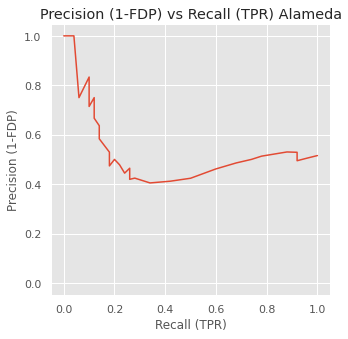

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) Alameda")
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, RocCurveDisplay
def spit_out_metrics(y_test, x_test, model):
  '''this function output the confusion matrix and ROC curve for the model.'''
  y_pred=model.predict(x_test)
  print('The accuracy score of ',str(model),'is',accuracy_score(y_test, y_pred))
  print('The recall score of  ',str(model),'is',recall_score(y_test, y_pred))
  print('The balanced accuracy score of ', str(model),'is',balanced_accuracy_score(y_test, y_pred))
  print('The f1_score of ',str(model),'is',f1_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  group_names = ['True Negative','False Positive','False Negative','True Positive']
  group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');
  ax.set_ylabel('Predicted Values')
  ax.set_xlabel('Actual Values')
  ax.set_title('Confusion Matrix of {}'.format(str(model)));
  roc_disp = RocCurveDisplay.from_estimator(model, x_test, y_test)
  fig = plt.figure(figsize=(8, 4))
  plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.4329896907216495
The recall score of   LogisticRegression(random_state=3) is 0.28
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.4378723404255319
The f1_score of  LogisticRegression(random_state=3) is 0.3373493975903614


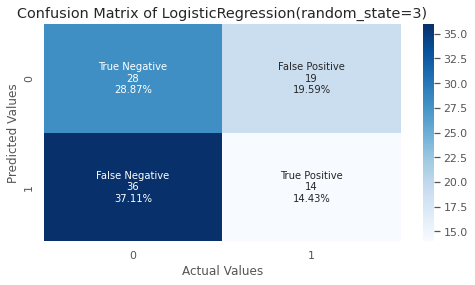

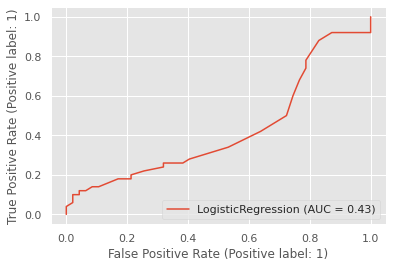

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 2
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:              -0.0002134
Time:                        22:33:16   Log-Likelihood:                -155.26
converged:                       True   LL-Null:                       -155.23
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

In [ ]:
X = la_merge_2020[['transit_stations_percent_change_from_baseline']]
y = la_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

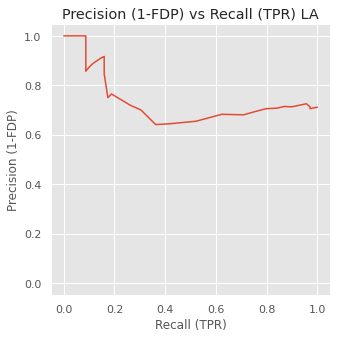

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) LA")
plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.7010309278350515
The recall score of   LogisticRegression(random_state=3) is 0.9855072463768116
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.4927536231884058
The f1_score of  LogisticRegression(random_state=3) is 0.8242424242424243


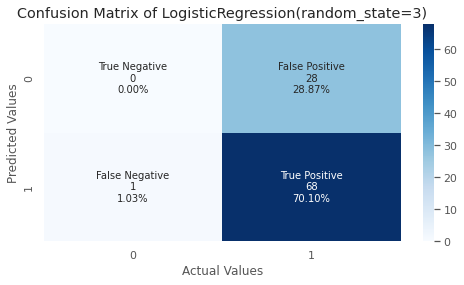

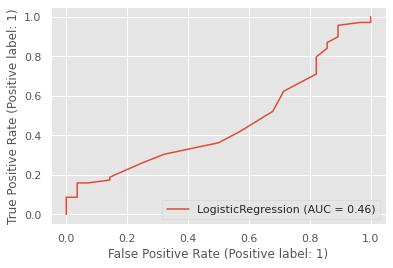

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.673726
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:                -0.01495
Time:                        22:14:53   Log-Likelihood:                -150.91
converged:                       True   LL-Null:                       -148.69
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

In [ ]:
X = sd_merge_2020[['transit_stations_percent_change_from_baseline']]
y = sd_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

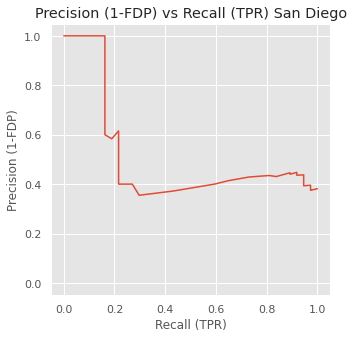

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) San Diego")
plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.6597938144329897
The recall score of   LogisticRegression(random_state=3) is 0.16216216216216217
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.5644144144144144
The f1_score of  LogisticRegression(random_state=3) is 0.26666666666666666


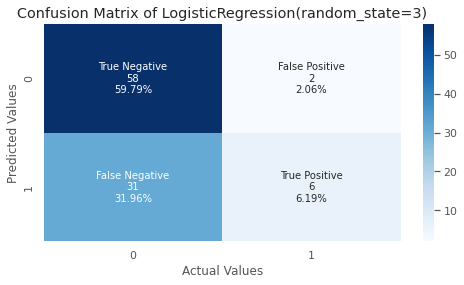

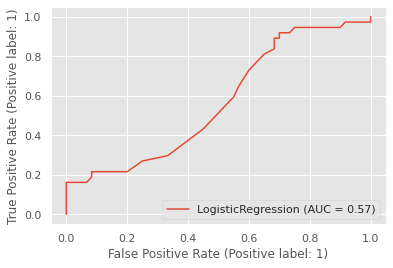

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.640729
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:                 0.01692
Time:                        22:14:55   Log-Likelihood:                -143.52
converged:                       True   LL-Null:                       -145.99
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

In [ ]:
X = fresno_merge_2020[['transit_stations_percent_change_from_baseline']]
y = fresno_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

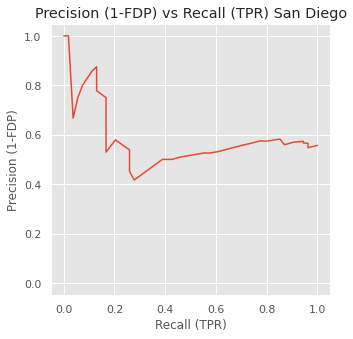

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) San Diego")
plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.4948453608247423
The recall score of   LogisticRegression(random_state=3) is 0.12962962962962962
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.5415590008613265
The f1_score of  LogisticRegression(random_state=3) is 0.2222222222222222


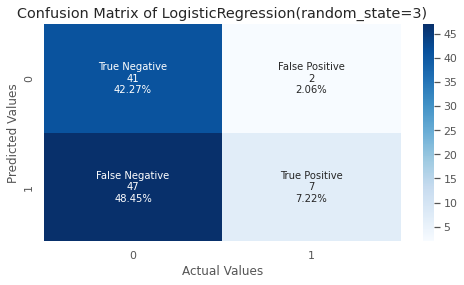

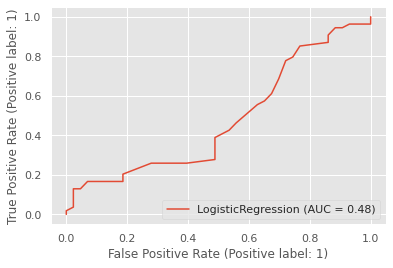

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.691357
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:                0.001146
Time:                        22:14:56   Log-Likelihood:                -154.86
converged:                       True   LL-Null:                       -155.04
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

In [ ]:
X = orange_merge_2020[['transit_stations_percent_change_from_baseline']]
y = orange_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

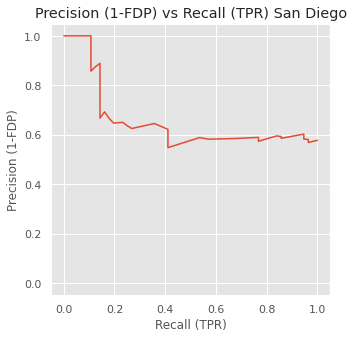

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) San Diego")
plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.5773195876288659
The recall score of   LogisticRegression(random_state=3) is 0.8571428571428571
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.5261324041811847
The f1_score of  LogisticRegression(random_state=3) is 0.7007299270072992


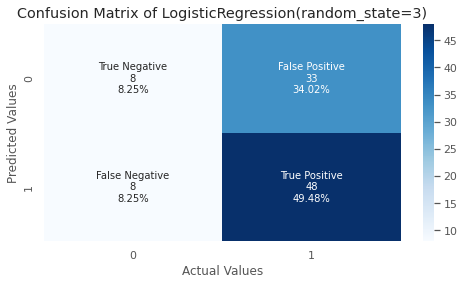

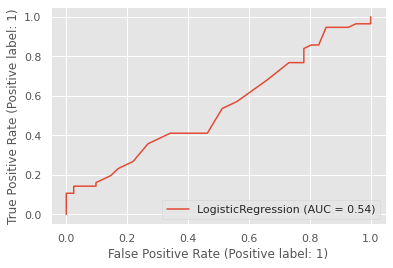

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.689554
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:               -0.009732
Time:                        22:14:57   Log-Likelihood:                -154.46
converged:                       True   LL-Null:                       -152.97
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

In [ ]:
X = sacramento_merge_2020[['transit_stations_percent_change_from_baseline']]
y = sacramento_merge_2020['No2_thres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr = LogisticRegression(random_state = 3)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

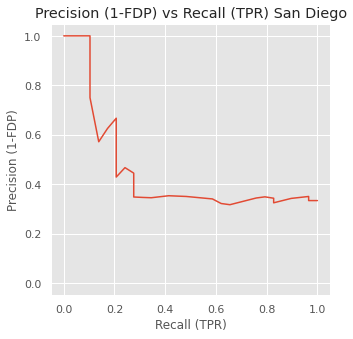

In [ ]:
predicted_probs = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR) San Diego")
plt.show()

The accuracy score of  LogisticRegression(random_state=3) is 0.711340206185567
The recall score of   LogisticRegression(random_state=3) is 0.13793103448275862
The balanced accuracy score of  LogisticRegression(random_state=3) is 0.5469066937119675
The f1_score of  LogisticRegression(random_state=3) is 0.2222222222222222


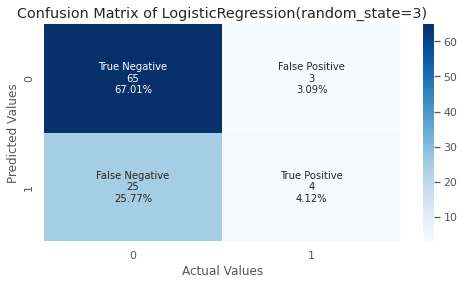

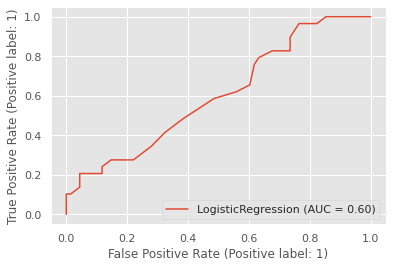

<Figure size 576x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8, 4))
spit_out_metrics(y_test, X_test, lr)

In [ ]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.583626
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              No2_thres   No. Observations:                  224
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            0
Date:                Mon, 09 May 2022   Pseudo R-squ.:                 0.02448
Time:                        22:14:58   Log-Likelihood:                -130.73
converged:                       True   LL-Null:                       -134.01
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
transit_stations_percent_change_from_b

Text(0.5, 0, 'k')

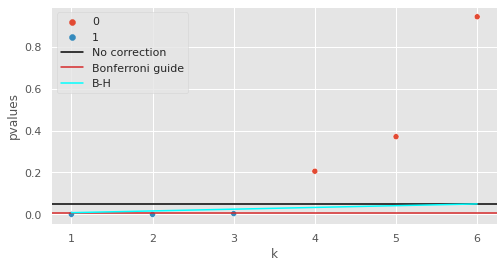

In [ ]:
p_values_series = np.array([0.004,0.206,0.943,0.000,0.371, 0.000])
is_alternative = np.array([1,0,0,1,0,1])
d = {'pvalues': p_values_series,"is_alternative" : is_alternative}
p_values = pd.DataFrame(data = d)
p_sorted = p_values.sort_values('pvalues')
N = 6
k = np.arange(1, N+1)
alpha = .05
fig = plt.figure(figsize=(8, 4))
sns.scatterplot(x=k, y=p_sorted['pvalues'], hue=p_sorted['is_alternative']);
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / N, label='Bonferroni guide', color='tab:red')
plt.plot(k, k/N * alpha, label='B-H', color='cyan')
plt.legend();
plt.xlabel("k")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b72eefb9-569f-4573-962c-24fe961cd27a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>